In [1]:
import pandas as pd
import numpy as np
import hvplot.xarray
import datetime as dt
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl

import sys
sys.path.append('C:/Users/mbonney/OneDrive - NRCan RNCan/Projects/UtilityCode/DataAccess/Utilities')
import PreProcess_Utils as pputil

sys.path.append('C:/Users/mbonney/OneDrive - NRCan RNCan/Projects/UtilityCode/Modelling/Utilities')
import Snow_Utils as snow_util

In [2]:
from dask.distributed import LocalCluster

cluster = LocalCluster(n_workers = 10, threads_per_worker = 10, memory_limit = 0) # Refined through testing, removing memory_limit is important
client = cluster.get_client()
client # Can open in other window by clicking 'Dashboard' link below

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 10
Total threads: 100,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:54355,Workers: 10
Dashboard: http://127.0.0.1:8787/status,Total threads: 100
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:54389,Total threads: 10
Dashboard: http://127.0.0.1:54416/status,Memory: 0 B
Nanny: tcp://127.0.0.1:54359,


In [3]:
# Calculated from IMS (4 SnowDynamics_IMS)
sstart_first = 248
send_last = 166
smin_avg = 205

In [4]:
w_s = 2020 # Year that winter ends
w_e = 2021 # Year that winter starts
winterYear = str(w_s)[2:] + str(w_e)[2:] 

path = r'C:\Users\mbonney\OneDrive - NRCan RNCan\Projects\High Resolution Snow Dynamics\Fmask_V1\AA\Alaska Snow Depth\1 HLS Fmask from STAC\fmask_nc'

# Full Process to Winter Year Snow Dynamics

In [5]:
%%time
c_s = pputil.uploadNC(path + '/fmask_AlaskaSite_' + str(w_s) + '.nc', 
                      form = 'dataarray',
                      chunks = {'time': 1, 'band': -1, 'x': -1, 'y': -1})
c_s

CPU times: total: 62.5 ms
Wall time: 815 ms


<xarray.DataArray 'stackstac-4a49170135b6085f2749f5154223a8f7' (time: 187,
                                                                band: 1,
                                                                y: 2436, x: 1581)> Size: 720MB
dask.array<open_dataset-stackstac-4a49170135b6085f2749f5154223a8f7, shape=(187, 1, 2436, 1581), dtype=uint8, chunksize=(1, 1, 2436, 1581), chunktype=numpy.ndarray>
Coordinates:
  * band           (band) <U5 20B 'Fmask'
  * x              (x) float64 13kB 3.995e+05 3.996e+05 ... 4.469e+05 4.469e+05
  * y              (y) float64 19kB 7.679e+06 7.679e+06 ... 7.606e+06 7.606e+06
    constellation  (time) <U3 2kB dask.array<chunksize=(1,), meta=np.ndarray>
  * time           (time) datetime64[ns] 1kB 2020-03-02 ... 2020-10-10
Attributes:
    spec:        RasterSpec(epsg=32606, bounds=(399510, 7606260, 446940, 7679...
    crs:         epsg:32606
    transform:   [ 3.00000e+01  0.00000e+00  3.99510e+05  0.00000e+00 -3.0000...
    resolution:  30

In [6]:
%%time
c_e = pputil.uploadNC(path + '/fmask_AlaskaSite_' + str(w_e) + '.nc', 
                      form = 'dataarray',
                      chunks = {'time': 1, 'band': -1, 'x': -1, 'y': -1})
c_e

CPU times: total: 15.6 ms
Wall time: 59 ms


<xarray.DataArray 'stackstac-00eb41efa210593677a260c6a0b07bfc' (time: 201,
                                                                band: 1,
                                                                y: 2436, x: 1581)> Size: 774MB
dask.array<open_dataset-stackstac-00eb41efa210593677a260c6a0b07bfc, shape=(201, 1, 2436, 1581), dtype=uint8, chunksize=(1, 1, 2436, 1581), chunktype=numpy.ndarray>
Coordinates:
  * band           (band) <U5 20B 'Fmask'
  * x              (x) float64 13kB 3.995e+05 3.996e+05 ... 4.469e+05 4.469e+05
  * y              (y) float64 19kB 7.679e+06 7.679e+06 ... 7.606e+06 7.606e+06
    constellation  (time) <U3 2kB dask.array<chunksize=(1,), meta=np.ndarray>
  * time           (time) datetime64[ns] 2kB 2021-03-02 ... 2021-10-10
Attributes:
    spec:        RasterSpec(epsg=32606, bounds=(399510, 7606260, 446940, 7679...
    crs:         epsg:32606
    transform:   [ 3.00000e+01  0.00000e+00  3.99510e+05  0.00000e+00 -3.0000...
    resolution:  30

In [7]:
%%time
snowCube = snow_util.annualFmask2SnowCube(c_s, c_e, yrs = 2, verbose = True) # yrs = 1, doy = doy
# Want to use 2 year cube to help get better results due to date gaps
snowCube

Initial Fmask time-steps: Start (n = 187), End (n = 201).
Made decision on same-day observations (L30vS30): Start (n = 148), End (n = 159).
Combined snow cube (n = 307).
Removed time-steps above 99% unclear pixels (n = 221).
Reclassifed (Snow = 1, Non-snow = 0, Unclear = NaN)
CPU times: total: 3.48 s
Wall time: 16.2 s


<xarray.DataArray 'stackstac-4a49170135b6085f2749f5154223a8f7' (time: 221,
                                                                y: 2436, x: 1581)> Size: 3GB
dask.array<where, shape=(221, 2436, 1581), dtype=float32, chunksize=(1, 2436, 1581), chunktype=numpy.ndarray>
Coordinates:
    band         <U5 20B 'Fmask'
  * x            (x) float64 13kB 3.995e+05 3.996e+05 ... 4.469e+05 4.469e+05
  * y            (y) float64 19kB 7.679e+06 7.679e+06 ... 7.606e+06 7.606e+06
  * time         (time) datetime64[ns] 2kB 2020-03-05 2020-03-06 ... 2021-10-10
    spatial_ref  int64 8B 0

In [8]:
thresh = 2 # Originally 3 but in some situations leads to extra uncertainty


if np.isnan(send_last) == True:
    implausible_snow = []
else: # Week buffer from latest recorded end date and earliest recorded start date
    implausible_snow = [send_last + 7, sstart_first - 7]

implausible_snow

[173, 241]

In [9]:
# %%time
# snowCube_c = snow_util.cleanSnowCube(snowCube, implausible_snow = implausible_snow, thresh = thresh)
# snowCube_c

In [10]:
# %%time
# snowCube_c = snow_util.dailySnowCube(snowCube_c, doy = int(tile_stats.loc[tile, 'smin_avg']), verbose = True)
# snowCube_c

In [11]:
# %%time
# snowDynamics = snow_util.dailySnowCube2SnowDynamics(snowCube_c, uncertainty = True, verbose = True) # Default settings
# snowDynamics

# Load Snow Cube

In [12]:
%%time
snowCube = pputil.loadXR(snowCube)
snowCube

CPU times: total: 17.7 s
Wall time: 33.3 s


<xarray.DataArray 'stackstac-4a49170135b6085f2749f5154223a8f7' (time: 221,
                                                                y: 2436, x: 1581)> Size: 3GB
array([[[ 1.,  1.,  1., ..., nan, nan, nan],
        [ 1.,  1.,  1., ..., nan, nan, nan],
        [ 1.,  1.,  1., ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ...,  1.,  1.,  1.],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 1.,  1.,  1., ..., nan, nan, nan],
        [ 1.,  1.,  1., ..., nan, nan, nan],
        [ 1.,  1.,  1., ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
    band         <U5 20B 'Fmask'
  * x            (x) float64 13kB 3.995e+05 3.996e+05 ... 4.469e+05 4.469e+05
  * y            (y) float64 19kB 7.679e+06 7.679e+06 ... 7.606e+06 7.606e+06
  * time         (time) datetime64[ns] 2kB 2020-03-05 2020-03-06 ... 2021-10-10
    spatial_ref  int64 8B 0

# Select good pixel(s)?
2000, 1150: Lots of noise around end date 1-0-1 etc., then implausible_snow filter removes real late June/July snow that helps stabilize

2000, 1065: Example of very long snow start uncertainty that impacts end uncertainty

2165, 1310: Noise around end date, but implausible snow filter has big impact (takes a month off date)

1700, 533: Steep terrace with noise around end date + over-aggressive implausible snow filter

In [25]:
x = 2150 #np.random.randint(0, snowCube.shape[1])
print(x)
y = 1300 #np.random.randint(0, snowCube.shape[2])
print(y)

print(snowCube[:, x, y]['x'].values) #.rio.set_spatial_dims('x', 'y').rio.reproject('EPSG:4326')
print(snowCube[:, x, y]['y'].values)

(snowCube[:, x, y].rename('Snow Cube') # To plot with hvplot
                  .dropna(dim = 'time') # Prepare for daily resample
                  .resample(time = '1D').interpolate('linear').astype('float32') # Linear daily resample
                  # Reindex to fill 2 year time-series?
                  .hvplot(height = 600, width = 1500) * # Drop na and interpolate na to see full picture

(snowCube[:, x, y].hvplot.scatter(marker = 'o', color = 'black', size = 15))) # Observation points

2150
1300
438525.0
7614825.0


:Overlay
   .Curve.I   :Curve   [time]   (Snow Cube)
   .Scatter.I :Scatter   [time]   (stackstac-4a49170135b6085f2749f5154223a8f7)

In [14]:
# dates = snowCube[:, x, y].time.values
# dates = [date[0:10] for date in np.datetime_as_string(dates)]

# obs = snowCube[:, x, y].values
# obs = [ob.item() for ob in obs]

# {dates: obs for dates, obs in zip(dates, obs)}

In [15]:
# snowCube[:, x, y]

In [16]:
con_e = c_e.squeeze()[:, x, y].constellation.values

dates_e = c_e.squeeze()[:, x, y].time.values
dates_e = [date[0:10] for date in np.datetime_as_string(dates_e)]
dates_e = dates_e + con_e

obs_e = c_e.squeeze()[:, x, y].values
obs_e = [ob.item() for ob in obs_e]

{dates_e: obs_e for dates_e, obs_e in zip(dates_e, obs_e)}

# fill (10) > cloud (9) > shadow (8) > cloud adjacent (7) > aerosol (snow: 6, water: 5, land: 4) > snow (3) > water (2) > land (1)

{np.str_('2021-03-02L30'): 9,
 np.str_('2021-03-04S30'): 8,
 np.str_('2021-03-06S30'): 8,
 np.str_('2021-03-07L30'): 10,
 np.str_('2021-03-07S30'): 8,
 np.str_('2021-03-09L30'): 9,
 np.str_('2021-03-10S30'): 10,
 np.str_('2021-03-11S30'): 3,
 np.str_('2021-03-12S30'): 3,
 np.str_('2021-03-14L30'): 10,
 np.str_('2021-03-16L30'): 6,
 np.str_('2021-03-16S30'): 3,
 np.str_('2021-03-17S30'): 7,
 np.str_('2021-03-18L30'): 7,
 np.str_('2021-03-19S30'): 7,
 np.str_('2021-03-20S30'): 10,
 np.str_('2021-03-21S30'): 3,
 np.str_('2021-03-22S30'): 9,
 np.str_('2021-03-23L30'): 10,
 np.str_('2021-03-25L30'): 9,
 np.str_('2021-03-25S30'): 10,
 np.str_('2021-03-26S30'): 7,
 np.str_('2021-03-27S30'): 8,
 np.str_('2021-03-29S30'): 9,
 np.str_('2021-03-30S30'): 10,
 np.str_('2021-03-31S30'): 9,
 np.str_('2021-04-01L30'): 9,
 np.str_('2021-04-01S30'): 9,
 np.str_('2021-04-03L30'): 8,
 np.str_('2021-04-03S30'): 3,
 np.str_('2021-04-05S30'): 9,
 np.str_('2021-04-06S30'): 7,
 np.str_('2021-04-08L30'): 10,
 n

## Method

### cleanSnowCube
- Resetting cumsum, threshold = 2

In [26]:
%%time

thresh = 2

snowCube_c = snow_util.cleanSnowCube(snowCube, form = 'binary', temporal = 'gaps', implausible_snow = implausible_snow, thresh = thresh) # snowCube[:, x-5:x+5, y-5:y+5] # snowCube
#snowCube_c

(snowCube_c[:, x, y].rename('Snow Cube') # To plot with hvplot # [:, 5, 5] # [:, x, y]
                    .dropna(dim = 'time') # Prepare for daily resample
                    .resample(time = '1D').interpolate('linear').astype('float32') # Linear daily resample
                    # Reindex to fill 2 year time-series?
                    .hvplot(height = 600, width = 1500) * # Drop na and interpolate na to see full picture
 
(snowCube_c[:, x, y].rename('s').hvplot.scatter(marker = 'o', color = 'black', size = 15))) # Observation points # [:, 5, 5] # [:, x, y]

Set all observations to non-snow between implausible snow dates (06-21 to 08-28).
Calculated cumulative sum that resets when non-snow is found.
Identified periods when 2+ consecutive snow observations occured (skipping NaN).
Created flipped snowCube to identify non-snow periods.
Calculated cumulative sum that resets when snow is found.
Identified periods when 2+ consecutive non-snow observations occured (skipping NaN).
Removed (NaN) snow and non-snow periods below 2 consecutive observations.
CPU times: total: 8min 27s
Wall time: 2min 3s


:Overlay
   .Curve.I   :Curve   [time]   (Snow Cube)
   .Scatter.I :Scatter   [time]   (s)

In [27]:
# # Just filter to 1 year for publication
# doy = int(tile_stats.loc[tile, 'smin_avg'])

# # Filter and (if needed) Reindex
# yr2 = int(snowCube_c.time.dt.year[-1]) # Last year represented in cube

# # Convert day-of-year to filterable strings
# if ((yr2 - 1) / 4).is_integer() == False: # Not a leap year
#     date1 = dt.datetime(yr2 - 1, 1, 1) + dt.timedelta(doy) # Day after first year
# if ((yr2 - 1) / 4).is_integer() == True: # Leap year
#     date1 = dt.datetime(yr2 - 1, 1, 1) + dt.timedelta(doy + 1) # Day after first year
# if (yr2 / 4).is_integer() == False: # Not a leap year (doy )
#     date2 = dt.datetime(yr2, 1, 1) + dt.timedelta(doy - 1) # Day-of-year next year
# if (yr2 / 4).is_integer() == True: # Leap year
#     date2 = dt.datetime(yr2, 1, 1) + dt.timedelta(doy) # Day-of-year next year

# start = f'{date1.year}-{date1.month:02d}-{date1.day:02d}'
# end =  f'{date2.year}-{date2.month:02d}-{date2.day:02d}'

# # Filter
# snowCube_c = snowCube_c.sel(time = slice(start, end))
# snowCube_c

In [28]:
# (snowCube_c[:, x, y].rename('Snow Cube') # To plot with hvplot # snowCube_c[:, 5, 5]
#                     .dropna(dim = 'time') # Prepare for daily resample
#                     .resample(time = '1D').interpolate('linear').astype('float32') # Linear daily resample
#                     # Reindex to fill 2 year time-series?
#                     .hvplot(height = 600, width = 1500) * # Drop na and interpolate na to see full picture
 
# (snowCube_c[:, x, y].rename('s').hvplot.scatter(marker = 'o', color = 'black', size = 15))) # Observation points # snowCube_c[:, 5, 5]

In [29]:
# snowCube_c[:, 5, 5]

In [30]:
%%time

snowCube_c = snow_util.dailySnowCube(snowCube_c, doy = smin_avg, verbose = True)
#snowCube_c

(snowCube_c[:, x, y].rename('Snow Cube') # To plot with hvplot # snowCube_c[:, 5, 5]
                    .hvplot(height = 600, width = 1200) * # Drop na and interpolate na to see full picture

(snowCube_c[:, x, y].rename('s').hvplot.scatter(marker = 'o', color = 'black', size = 15))) # Observation points # snowCube_c[:, 5, 5]

Filled in all NaNs in snowCube with linearly interpolated values in time.
Resampled to daily snowCube (2020-03-05 to 2021-10-10, n = 585) using linear interpolation.
Filtered to winter year (2020-07-25 to 2021-07-24, n = 365).
Reinidexing not required since daily snowCube already contains all possible dates.


C:\Users\mbonney\Miniforge3\envs\snow_hls_2025\Lib\site-packages\distributed\client.py:3370: UserWarning: Sending large graph of size 127.58 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
C:\Users\mbonney\Miniforge3\envs\snow_hls_2025\Lib\site-packages\distributed\client.py:3370: UserWarning: Sending large graph of size 127.58 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: total: 11.4 s
Wall time: 33.1 s


:Overlay
   .Curve.I   :Curve   [time]   (Snow Cube)
   .Scatter.I :Scatter   [time]   (s)

In [31]:
# # Binary cube
# snowCube_b = xr.where(snowCube_c >= 0.4999, 1, snowCube_c) # If no uncertainty (e.g., IMS - don't need this)
# snowCube_b = xr.where(snowCube_c < 0.4999, 0, snowCube_b) # 0.4999 accounts for weird rounding in some cases

# (snowCube_b[:, x, y].rename('Binary Snow Cube') # To plot with hvplot # snowCube_b[:, 5, 5]
#                     .hvplot(height = 600, width = 1200) * # Drop na and interpolate na to see full picture

# (snowCube_b[:, x, y].rename('s').hvplot.scatter(marker = 'o', color = 'black', size = 15))) # Observation points # snowCube_b[:, 5, 5]

In [32]:
# # Uncertainty cube
# snowCube_u = xr.where((snowCube_c < 0.005) | (snowCube_c > 0.995), 0, snowCube_c)
# snowCube_u = xr.where((snowCube_c >= 0.005) & (snowCube_c <= 0.995) , 1, snowCube_u) 

# (snowCube_u[:, x, y].rename('Uncertainty Snow Cube') # To plot with hvplot # snowCube_u[:, 5, 5]
#                     .hvplot(height = 600, width = 1200) * # Drop na and interpolate na to see full picture

# (snowCube_u[:, x, y].rename('s').hvplot.scatter(marker = 'o', color = 'black', size = 15))) # Observation points # snowCube_u[:, 5, 5]

### snowDynamics stats

In [33]:
%%time

snowDynamics = snow_util.dailySnowCube2SnowDynamics(snowCube_c, products = ['start', 'end', 'length', 'periods', 'status'], uncertainty = True, verbose = True)
#snowDynamics

print('Snow status: ' + str(snowDynamics['snow_status'][x,y].values)) # [5,5]
print('Snow periods: ' + str(snowDynamics['snow_periods'][x,y].values)) # [5,5]
print('Snow start: ' + str(snowDynamics['snow_start'][x,y].values)) # [5,5]
print('Snow start uncertainty: ' + str(snowDynamics['snow_start_u'][x,y].values)) # [5,5]
print('Snow end: ' + str(snowDynamics['snow_end'][x,y].values)) # [5,5]
print('Snow end uncertainty: ' + str(snowDynamics['snow_end_u'][x,y].values)) # [5,5]
print('Snow length: ' + str(snowDynamics['snow_length'][x,y].values)) # [5,5]
print('Snow length uncertainty: ' + str(snowDynamics['snow_length_u'][x,y].values)) # [5,5]

Created empty snowDynamics Dataset to fill.
Created binary snowCube (>= 0.5 = 1, < 0.5 = 0).
Calculated cumulative sum of binary snowCube (used in multiple products).
Added snow cover start date (# days from Dec 31) to snowDynamics.
Added snow cover end date (# days from Dec 31) to snowDynamics.
Added snow cover length (# days with snow cover) to snowDynamics.
Added snow period count (# seperated snow periods) to snowDynamics.
Added snow status (0 = Regular fall/melt, 1 = Perennial, 2 = Inconsistent perennial, 3 = Snow free) to snowDynamics.
Created uncertainty snowCube (>= 0.005 & <= 0.995 = 1, else = 0).


C:\Users\mbonney\Miniforge3\envs\snow_hls_2025\Lib\site-packages\distributed\client.py:3370: UserWarning: Sending large graph of size 3.17 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Used 195 day gap between latest snow start (2020-10-09) and earliest snow end (2021-04-22) to find winter year split day: 2021-01-14.
Added snow start uncertainty (# days between last non-snow and first snow observation / 2) to snowDynamics.
Added snow end uncertainty (# days between last snow and first non-snow observation / 2) to snowDynamics.
Added snow length uncertainty (total # days between snow and non-snow observations / 2) to snowDynamics.


C:\Users\mbonney\Miniforge3\envs\snow_hls_2025\Lib\site-packages\distributed\client.py:3370: UserWarning: Sending large graph of size 127.59 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Snow status: 0
Snow periods: 1
Snow start: -4.0
Snow start uncertainty: 48.5
Snow end: 175.0
Snow end uncertainty: 47.0
Snow length: 180
Snow length uncertainty: 95.5
CPU times: total: 1min 41s
Wall time: 5min 45s


C:\Users\mbonney\Miniforge3\envs\snow_hls_2025\Lib\site-packages\distributed\client.py:3370: UserWarning: Sending large graph of size 3.17 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


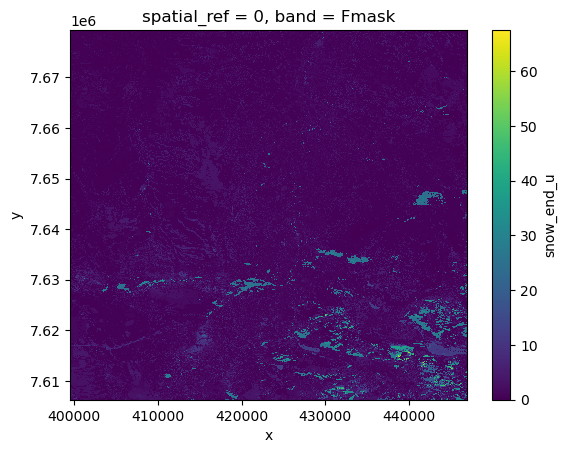

In [34]:
snowDynamics['snow_end_u'].plot()